Let's consider how a parallel running scheme ought to work

In [14]:
# may be fun to have things be read in from txt file with params
from importlib import reload
import os
import GagePreprocess as gp
import numpy as np
import pickle as pkl
import time

reload(gp)

<module 'GagePreprocess' from '/Users/taixiang/Documents/UltracoldRepos/DataManagement2023/Newest/GagePreprocess.py'>

In [15]:
def naive_impl(save_path, jkam_path, gage_path):
    # TODO: nothing fancy, just keep stacking more and more pickl files after waiting 15 seconds
    curr_files = []
    new_files = []
    curr_cmplx_path = ''
    curr_time_path = ''
    first_step = True
    curr_time_pkl = ''
    curr_cmplx_pkl = ''
    former_time_pkl = ''
    former_cmplx_pkl = ''
    curr_cmplx_arr = []
    curr_time_arr = []
    # TODO: there's something weird going on with how things are indexed in jkam
    # TODO: bug: if jkam gets files before gage, there will be a bug in the file mask
    # gage will basically try and index up to jkam file number and will go out of range
    curr_length = len(os.listdir(gage_path))
    first_run = True
    while True:
        print("Current length of gage path: ", curr_length)
        new_length = len(os.listdir(gage_path))
        if first_run or new_length > curr_length:
            # need try except since mismatch between jkam files and gage files will break the thing
            try:
                cmplx_path, time_path, cmplx_amp, time_amp = gp.process_gage_pkl(save_path, 
                                                                                'run0', 
                                                                                286,
                                                                                3, 
                                                                                'high NA Imaging testenv', 
                                                                                'gage testenv')
                print("files processed again. current file number is : ", new_length)
                time.sleep(2)
                first_run = False
                curr_length = new_length
            except Exception as e:
                print("processing failed. The following error occurred: ", e)
            time.sleep(4)
        else:
            print("No new files to process.")
            time.sleep(4)
            continue
    

Current length of gage path:  152
num_frames =  3
jkam shots:  152
0
num jkam shots,  152
Hard reset, loading 152 shots from gage raw data
shot0 done


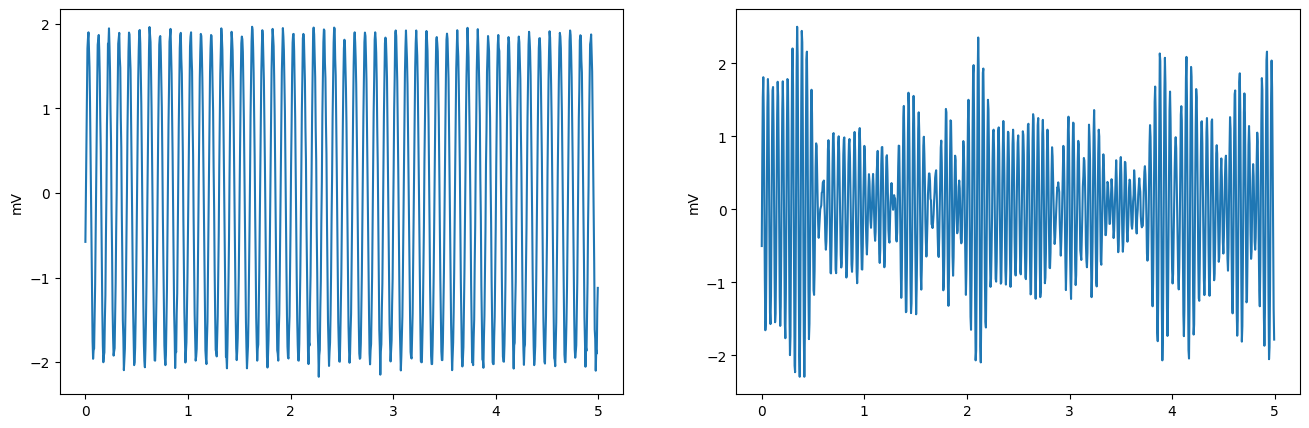

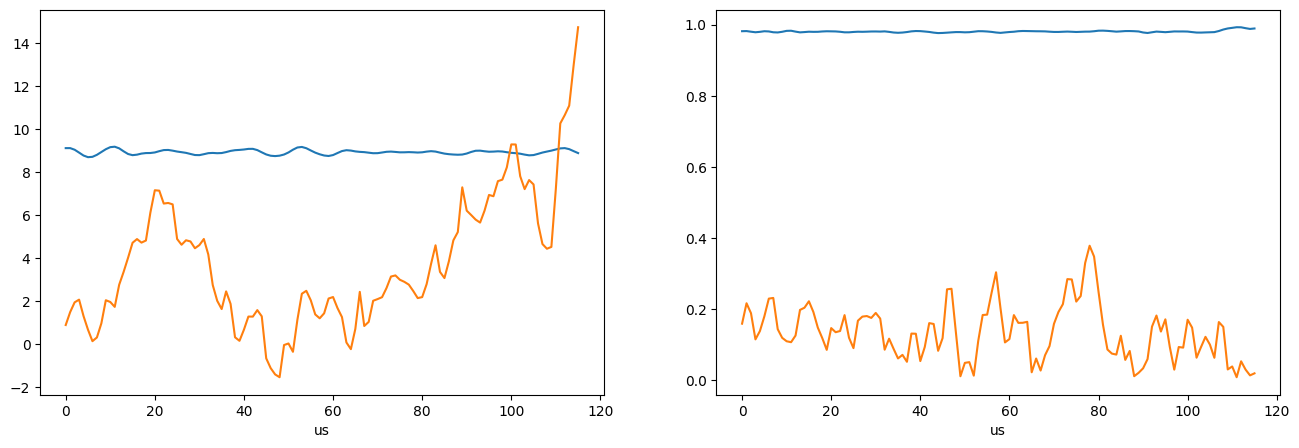

shot100 done
Writing new pkl file to:  TestPkl/run0_hann_gage_cmplx_amp_5_1.pkl
done
files processed again. current file number is :  152
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
No new files to process.
Current length of gage path:  152
num_frames =  3
jkam shots:  201
0
num jkam shots,  201
Hard reset, loading 201 shots from gage raw data
shot0 done


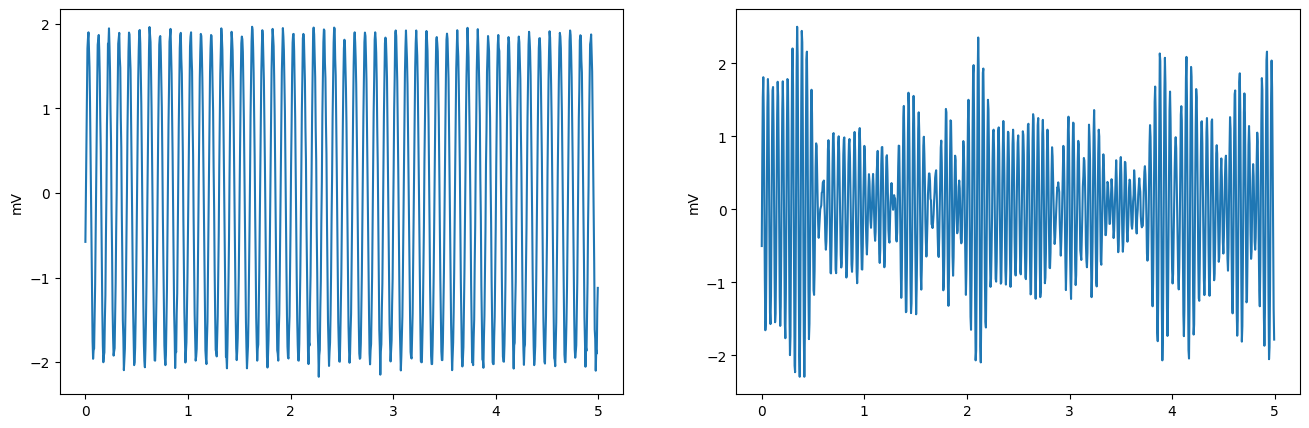

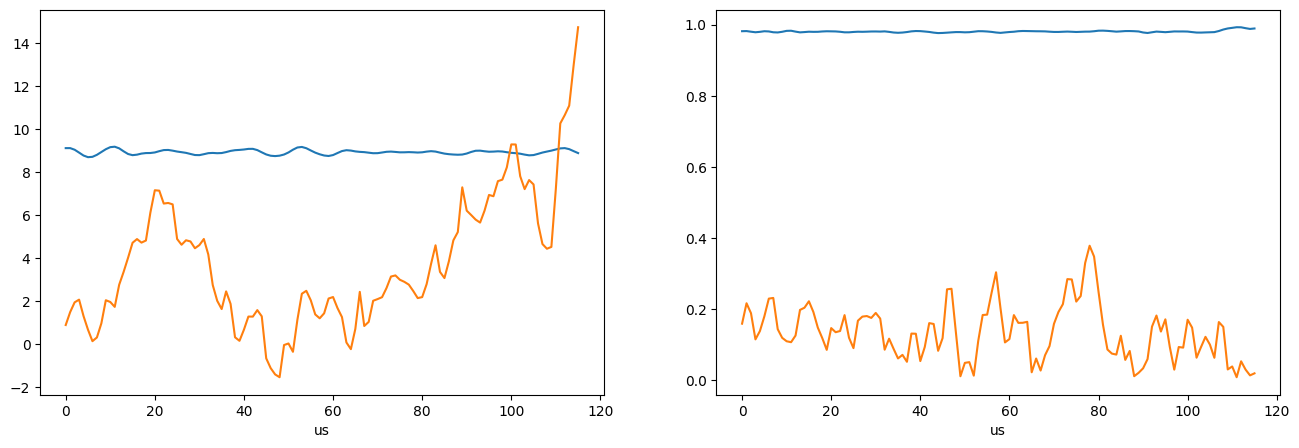

shot100 done
shot200 done
Writing new pkl file to:  TestPkl/run0_hann_gage_cmplx_amp_5_1.pkl
done
files processed again. current file number is :  201
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.
Current length of gage path:  201
No new files to process.


KeyboardInterrupt: 

In [16]:
naive_impl('TestPkl', 'High NA Imaging testenv', 'gage testenv')

In [ ]:
# given two pkl file paths, combine them into a single pkl file
def pkl_combiner(pkl1, pkl2):
    # load the pkl files, data are arrays
    data1 = gp.load_pkl(pkl1)
    data2 = gp.load_pkl(pkl2)
    # combine the data
    data = np.concatenate((data1, data2), axis=0)
    # repickle the data
    with open(pkl2, 'wb') as f:
        pkl.dump(data, f)
    

In [ ]:
def pkl_deleter(pkl_files, dir_path):
    if len(pkl_files) >= 3:
        # delete the one with the earliest creation time
        ctimes = [os.path.getctime(os.path.join(dir_path, name)) for name in pkl_files]
        min_ctime_idx = ctimes.index(min(ctimes))
        os.remove(os.path.join(dir_path, pkl_files[min_ctime_idx]))
        print("Old pkl file removed")

In [ ]:
def gage_match_check(file_list, file_number, increment_number):
    # for example if we are at file 50 with increment 5, we should expect to see the files 44, 45, 46, 47, 48, 49
    correct_suffix = file_number - increment_number - 1
    correct_files = [f for f in file_list if str(correct_suffix) in f.split('_')[-1].lstrip('0')]

    

In [ ]:
def cycle_process(save_path, file_incr, jkam_path = 'High NA Imaging testenv', gage_path = 'gage testenv'):
    curr_files = []
    new_files = []
    curr_cmplx_path = ''
    curr_time_path = ''
    first_step = True
    file_num = file_incr
    curr_time_pkl = ''
    curr_cmplx_pkl = ''
    former_time_pkl = ''
    former_cmplx_pkl = ''
    curr_cmplx_arr = []
    curr_time_arr = []

    # get num files in folder
    total_files = len([name for name in os.listdir(gage_path) if os.path.isfile(os.path.join(gage_path, name))])
    if total_files >= file_num and first_step:
        print("first step \n")
        # store all file names
        curr_files = [name for name in os.listdir(gage_path) if os.path.isfile(os.path.join(gage_path, name))]
        # files tend to get read in out of order and need to be ordered
        new_files = curr_files
        print(curr_files)
        print(new_files)
        # TODO: need edge cases to check that gage number match amount of files added, just in case there are extras and the sequence gets messed up
        # run preprocessor on new files

        # TODO: need to send new files into gage preprocessing instead of just a path
        # TODO: all additional checks need to be done on the segmented files...
        curr_amp_path, curr_time_path, curr_amp, curr_time = gp.process_gage_pkl(out_path = save_path, 
                                                                run_name = 'run0', 
                                                                num_shots_manual = 286,
                                                                num_frames = 3,
                                                                jkam_path = jkam_path,
                                                                gage_path = gage_path,
                                                                jkam_prefix = 'jkam_capture',
                                                                gage_prefix = 'gage_shot')
        # we also need to output filepath of pkl files
        first_step = False
        file_num += file_incr

    elif total_files >= file_num:
        print("enough files incremented, executing again... \n")
        curr_files = [name for name in os.listdir(gage_path) if os.path.isfile(os.path.join(gage_path, name))]
        new_files = [x for x in curr_files if x not in new_files]
        former_time_pkl = curr_time_pkl
        former_cmplx_pkl = curr_cmplx_pkl   
        # run preprocessor on new files
        curr_amp_path, curr_time_path, curr_amp, curr_time = gp.process_gage_pkl(out_path = save_path, 
                                                                run_name = 'run0', 
                                                                num_shots_manual = 286,
                                                                num_frames = 3,
                                                                jkam_path = jkam_path,
                                                                gage_path = gage_path,
                                                                jkam_prefix = 'jkam_capture',
                                                                gage_prefix = 'gage_shot')
        # combine new and old pkl files
        pkl_combiner(former_time_pkl, curr_time_path)
        pkl_combiner(former_cmplx_pkl, curr_amp_path)

        dir_path = os.path.dirname(former_time_pkl)
        # get if there are three files that are .pkl in this directory
        amp_pkl_files = [name for name in os.listdir(dir_path) 
                    if os.path.isfile(os.path.join(dir_path, name)) and name.endswith('.pkl') and 'cmplx_amp' in name]
        time_pkl_files = [name for name in os.listdir(dir_path) 
                    if os.path.isfile(os.path.join(dir_path, name)) and name.endswith('.pkl') and 'time' in name]
        
        pkl_deleter(amp_pkl_files, dir_path)
        pkl_deleter(time_pkl_files, dir_path)

    else:
        print("not enough files, waiting... \n")

In [ ]:
cycle_process(save_path = 'High NA Imaging testenv', file_incr=3)

In [ ]:
def main(file_incr):
    while True:
        time.sleep(2)
        cycle_process('out', file_incr)
        print("cycled once")

In [ ]:
main(3)